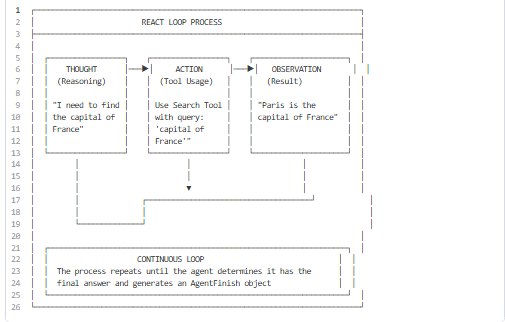


---

## **Table of Contents**
1. [Conceptual Introduction: The Problem AI Agents Solve](#1-conceptual-introduction)
2. [Technical Definition and Core Characteristics](#2-technical-definition)
3. [The ReAct Design Pattern](#3-react-design-pattern)
4. [Technical Implementation in LangChain](#4-technical-implementation)
5. [Execution Flow Deep Dive](#5-execution-flow)
6. [Enhanced Implementation: Custom Tools](#6-enhanced-implementation)
7. [Future: LangGraph for Production Applications](#7-future-langgraph)
8. [Summary and Key Takeaways](#8-summary)

---

## **1. Conceptual Introduction: The Problem AI Agents Solve**

### **Traditional Web Interaction Challenges**
In conventional web interactions, users face significant manual overhead for complex tasks. Consider planning a trip from **Delhi to Goa**:

- **Manual Research**: Visiting multiple sites (IRCTC, MakeMyTrip, Booking.com)
- **Decision Overload**: Comparing flights, trains, hotels, and attractions
- **Time-Consuming**: Hours of research and booking management
- **Error-Prone**: Missing details, double bookings, or overlooked alternatives

### **AI Agent Solution**
AI Agents revolutionize this process by providing **natural, conversational interaction**. Instead of manual web surfing, users provide high-level goals:

> *"Plan a 7-day budget trip to Goa from May 1-7"*

The agent then autonomously:
- **Understands intent** and key requirements
- **Plans travel options** by comparing multiple APIs
- **Finds accommodations** matching budget criteria
- **Suggests local transport** solutions
- **Manages bookings** and sends confirmations
- **Creates itineraries** and updates calendars

---

## **2. Technical Definition and Core Characteristics**

### **What is an AI Agent?**
An **AI Agent** is an intelligent system that receives high-level goals and **autonomously plans, decides, and executes** sequences of actions using external tools, APIs, or knowledge sources.

### **The Fundamental Equation**
```
AI Agent = LLM (Reasoning Engine) + Tools (Action Mechanism)
```

- **LLM**: Acts as the **brain** for reasoning and decision-making
- **Tools**: Act as **hands and feet** for real-world interaction

### **Core Characteristics**

| Characteristic | Description | Example |
|---|---|---|
| **Goal-Driven** | Define *what* to do, agent figures out *how* | "Find best restaurants in Mumbai" |
| **Planning** | Breaks complex problems into steps | Search → Filter → Compare → Recommend |
| **Tool Awareness** | Knows available tools and when to use them | Web search, database queries, API calls |
| **Context/Memory** | Maintains execution history and user preferences | Remembers budget constraints |
| **Adaptivity** | Adjusts plans when tools fail | Switch from flight to train booking |

---

## **3. The ReAct Design Pattern**

### **ReAct: Reasoning + Acting**
The **ReAct** pattern enables language models to interleave internal reasoning with external actions in structured, multi-step processes.

### **The Thought-Action-Observation Loop**

```
┌─────────────┐    ┌──────────┐    ┌──────────────┐
│   Thought   │───▶│  Action  │───▶│ Observation  │
│(Reasoning)  │    │(Tool Use)│    │(Result)      │
└─────────────┘    └──────────┘    └──────────────┘
         ▲                                    │
         │                                    │
         └────────────────────────────────────┘
```

### **Loop Process**
1. **Thought**: Agent reasons about next steps
   - *"I need to find the capital of France"*
2. **Action**: Agent selects and uses appropriate tool
   - *Uses Search Tool with input "capital of France"*
3. **Observation**: Tool returns result
   - *"Paris"*
4. **Repeat**: Loop continues until final answer

### **Benefits of ReAct**
- **Transparency**: Users see the agent's reasoning process
- **Flexibility**: Adapts to new information during execution
- **Reliability**: Can recover from tool failures

---

## **4. Technical Implementation in LangChain**

### **Core Components Required**
Building an agent requires three essential components:
1. **Set of Tools**: Action mechanisms
2. **LLM**: Reasoning engine
3. **Prompt**: Agent behavior guidelines

### **Basic Implementation Code**

```python
# Install required libraries
# !pip install langchain-openai langchain-community duckduckgo-search

from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun
from langchain.agents import create_react_agent, AgentExecutor
from langchain import hub

# 1. Define the LLM (Reasoning Engine)
llm = ChatOpenAI(model="gpt-3.5-turbo")

# 2. Define the Tools (Action Mechanism)
search_tool = DuckDuckGoSearchRun()
tools = [search_tool]

# 3. Load Pre-defined ReAct Prompt
prompt = hub.pull("hwchase17/react")

# 4. Create the Agent (Thinker)
agent = create_react_agent(llm, tools, prompt)

# 5. Create Agent Executor (Executioner)
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True  # Shows thought process
)

# 6. Execute Agent Query
result = agent_executor.invoke({
    "input": "What are the three ways to reach Goa from Delhi?"
})
print(result)
```

### **Agent vs. Agent Executor**

| Component | Role | Responsibility |
|-----------|------|----------------|
| **Agent** | Thinker | Plans steps, decides tool usage |
| **Agent Executor** | Executioner | Calls tools, manages execution, returns results |

---

## **5. Execution Flow Deep Dive**

### **Internal Loop Process**

```
┌─────────────────┐    ┌─────────────┐    ┌─────────────────┐
│ Agent Executor  │───▶│   Agent     │───▶│ Agent Executor  │
│ (Input Query)   │    │ (Reasoning) │    │ (Tool Execution)│
└─────────────────┘    └─────────────┘    └─────────────────┘
         │                       │                   │
         │               ┌───────┴───────┐           │
         │               │ Agent Scratch │           │
         │               │   (Memory)    │           │
         │               └───────────────┘           │
         └───────────────────────────────────────────┘
```

### **Step-by-Step Execution**

1. **Input Reception**: Agent Executor receives query and scratchpad
2. **Reasoning Phase**: Agent generates Thought and AgentAction
3. **Action Execution**: Agent Executor calls specified tool
4. **Observation Processing**: Result added to scratchpad
5. **Loop Continuation**: Updated scratchpad returned to agent
6. **Completion**: Agent generates AgentFinish with final answer

---

## **6. Enhanced Implementation: Custom Tools**

### **Creating Custom Tools with APIs**

```python
from langchain.agents import tool
import requests

@tool
def get_weather(city: str) -> str:
    """
    Returns current weather conditions for a given city.
    
    Args:
        city (str): Name of the city
    
    Returns:
        str: Weather information including temperature and conditions
    """
    api_key = "YOUR_API_KEY"
    url = f"http://api.weatherstack.com/current?access_key={api_key}&query={city}"
    
    try:
        response = requests.get(url).json()
        weather_info = f"""
        Temperature: {response['current']['temperature']}°C
        Condition: {response['current']['weather_descriptions'][0]}
        Humidity: {response['current']['humidity']}%
        Wind Speed: {response['current']['wind_speed']} km/h
        """
        return weather_info
    except Exception as e:
        return f"Error fetching weather data: {str(e)}"

# Integrate custom tool with existing tools
tools = [search_tool, get_weather]

# Re-initialize agent with new tools
agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

# Test with multi-tool query
result = agent_executor.invoke({
    "input": "Find the capital of Madhya Pradesh and then get its current weather."
})
print(result)
```

### **Advanced Tool Example: Database Query Tool**

```python
@tool
def query_database(query: str) -> str:
    """
    Executes SQL query on company database.
    
    Args:
        query (str): SQL query string
    
    Returns:
        str: Query results
    """
    # Implementation would connect to database
    # Execute query and return formatted results
    pass

# Example usage in agent
tools = [search_tool, get_weather, query_database]
```

---

## **7. Future: LangGraph for Production Applications**

### **Limitations of LangChain's AgentExecutor**
- **Scalability**: Not optimized for high-throughput applications
- **State Management**: Limited control over agent state
- **Complex Workflows**: Difficult to implement multi-agent systems

### **LangGraph: The Next Generation**
**LangGraph** is LangChain's specialized library for building:
- **Stateful applications**: Maintain complex agent states
- **Multi-actor systems**: Coordinate multiple agents
- **Production-ready workflows**: Handle enterprise requirements

### **Key Advantages of LangGraph**
- **Better State Management**: Advanced state tracking and persistence
- **Scalability**: Optimized for high-performance applications
- **Flexibility**: Custom workflow patterns and conditional logic
- **Monitoring**: Built-in observability and debugging tools

---

## **8. Summary and Key Takeaways**

### **Core Concepts**
- **AI Agents** = LLM (Reasoning) + Tools (Action)
- **ReAct Pattern** enables reasoning + action loops
- **Goal-driven** with autonomous planning capabilities

### **Implementation Steps**
1. Define LLM as reasoning engine
2. Create/define tools for external actions
3. Use pre-built or custom prompts
4. Create agent and executor
5. Execute queries and monitor results

### **Best Practices**
- Start simple with basic tools
- Gradually add complexity
- Implement proper error handling
- Consider using LangGraph for production applications
- Maintain clear documentation for custom tools

### **Analogy for Understanding**
Think of the agent workflow like a **head chef and kitchen assistant team**:
- **Chef (LLM)**: Plans the dish, decides next steps
- **Assistant (Agent Executor)**: Executes specific tasks, gathers ingredients
- **Communication**: Clear instructions and feedback loop
- **Final Product**: Completed dish (final answer)

---





---

## **AI Agents in LangChain — Interview-Style Q&A**

---

### **Q1. What problem do AI Agents solve?**

AI Agents address the inefficiency of manual, multi-step decision-making across disconnected systems.

In traditional workflows, a user must:

* Interpret requirements
* Search multiple platforms
* Compare options manually
* Execute actions one by one
* Track results independently

For example, planning a trip from Delhi to Goa requires:

* Searching flights or trains
* Comparing hotels
* Evaluating costs
* Booking tickets
* Managing schedules

An AI Agent replaces this fragmented workflow with a **single goal-driven interaction**, where the system plans, executes, and adapts autonomously.

---

### **Q2. What is an AI Agent in technical terms?**

An AI Agent is a system that combines:

* **Reasoning** (LLM)
* **Action execution** (tools, APIs)
* **State tracking**
* **Decision logic**

Formally:

> **AI Agent = LLM + Tools + Planning + Memory**

The LLM handles reasoning, while tools enable interaction with external systems such as APIs, databases, or services.

---

### **Q3. How is an AI Agent different from a normal LLM?**

| Feature                | LLM       | AI Agent    |
| ---------------------- | --------- | ----------- |
| Text generation        | Yes       | Yes         |
| Tool usage             | No        | Yes         |
| Decision making        | Limited   | Goal-driven |
| Memory                 | Stateless | Stateful    |
| Autonomy               | None      | High        |
| Real-world interaction | No        | Yes         |

An LLM generates responses.
An agent **decides actions and executes them**.

---

### **Q4. What are the core characteristics of an AI Agent?**

1. **Goal-driven execution**
   Works toward a user-defined outcome.

2. **Planning capability**
   Breaks a task into ordered steps.

3. **Tool awareness**
   Knows which tools exist and when to use them.

4. **Memory and context**
   Maintains execution history and observations.

5. **Adaptability**
   Can change strategy if a tool fails or data changes.

---

### **Q5. What is the ReAct pattern?**

ReAct stands for **Reasoning + Acting**.

It is the dominant agent design pattern used in LangChain.

#### Execution loop:

1. **Thought** – Decide next step
2. **Action** – Call a tool
3. **Observation** – Receive tool output
4. **Repeat** until task completion

This loop enables structured reasoning combined with real-world actions.

---

### **Q6. What components are required to build an agent in LangChain?**

Three core components:

1. **LLM**

   * Performs reasoning
   * Decides next actions

2. **Tools**

   * External APIs or functions
   * Example: Search, Weather API, Database query

3. **Prompt**

   * Defines agent behavior
   * Usually based on ReAct format

---

### **Q7. How does a basic LangChain agent work internally?**

Execution flow when calling `agent_executor.invoke()`:

1. User input sent to agent
2. Agent generates a reasoning step
3. Agent selects a tool
4. Tool is executed by Agent Executor
5. Result returned as observation
6. Observation added to memory
7. Loop continues until final answer

This loop is deterministic and traceable.

---

### **Q8. What is the difference between Agent and Agent Executor?**

| Component      | Responsibility                     |
| -------------- | ---------------------------------- |
| Agent          | Decides what to do                 |
| Agent Executor | Executes actions and manages tools |

The agent thinks.
The executor acts.

---

### **Q9. How do you add custom tools to an agent?**

Custom tools are defined using decorators and exposed to the agent.

Example use cases:

* Weather API
* Payment systems
* Internal databases
* CRM systems

The agent:

1. Identifies need for data
2. Calls tool with arguments
3. Receives structured output
4. Uses result in reasoning

This allows chaining multiple APIs in a single request.

---

### **Q10. How does the agent combine multiple tools in one task?**

Example flow:

1. Search tool finds a city name
2. Weather tool fetches conditions
3. Agent merges both outputs
4. Returns final answer

The agent dynamically decides:

* Which tool to use
* In what order
* With what inputs

No hardcoding of steps is required.

---

### **Q11. What are the limitations of AgentExecutor?**

AgentExecutor works well for:

* Prototypes
* Simple automation
* Linear workflows

Limitations:

* Hard to scale
* Limited control over execution flow
* Weak state management
* Poor observability for production systems

---

### **Q12. What is LangGraph and why is it used?**

LangGraph is a framework for building **stateful, multi-step, production-grade agents**.

It provides:

* Explicit state graphs
* Branching logic
* Error recovery
* Multi-agent coordination
* Deterministic execution paths

LangGraph replaces implicit loops with **explicit state machines**.

---

### **Q13. Conceptual analogy for understanding agents**

An AI Agent works like:

* **Chef (LLM)** → Decides what to do
* **Kitchen assistant (Tools)** → Performs actions
* **Recipe (Prompt)** → Defines behavior
* **Kitchen counter (Memory)** → Stores progress

The chef never cooks directly.
The chef instructs, evaluates, and adapts.

---

### **Q14. When should you use AI Agents?**

Use agents when:

* Tasks require multiple steps
* External APIs are involved
* Decisions depend on intermediate results
* Automation must adapt dynamically

Do not use agents for:

* Simple Q&A
* Static transformations
* Deterministic pipelines

---

### **Summary**

AI Agents:

* Extend LLMs with action capability
* Use reasoning + tools
* Operate in structured loops
* Enable real-world automation
* Scale best using LangGraph

They represent the shift from **text generation** to **autonomous systems**.

---

